# Shamecca Marshall

# Project 3: Classification of Gender based on Names

# Problem Description
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

# Importing the Packages

In [25]:
import nltk
from nltk.corpus import names
import random
import numpy
import pandas

from nltk.metrics import *

import re
    
import operator
import string
from textstat.textstat import textstat

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

# set display digits
display_digits=4


# inline matplotlib
%matplotlib inline

In [26]:
nltk.download('names')

[nltk_data] Downloading package names to /Users/MECCA/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [27]:
names_lst = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

In [30]:
random_seed=1234678
random.seed(random_seed)
random.shuffle(names_lst)

# let's see what the randomly shuffles names look like
names_lst[1:15]

[('Blanche', 'female'),
 ('Esme', 'female'),
 ('Chloris', 'female'),
 ('Poul', 'male'),
 ('Arne', 'male'),
 ('Johannah', 'female'),
 ('Beverlie', 'female'),
 ('Sibley', 'female'),
 ('Carmelia', 'female'),
 ('Garrott', 'male'),
 ('Ahmed', 'male'),
 ('Sibbie', 'female'),
 ('Roy', 'male'),
 ('Sid', 'male')]

# Splitting the Data

To construct our model effectively, it's essential to partition our data into three distinct subsets, each serving a specific purpose. The dataset contains a total of 7944 names. Among these, 7444 entries will be allocated for developmental purposes, with 6900 earmarked for training and 500 for testing. The remaining 500 entries will be reserved exclusively for the final model evaluation.

The breakdown of subsets is as follows:

Development Set:
- 6900 names designated for training (train_names)
- 500 names allocated for testing during development (devtest_names)

Test Set:
- 500 names exclusively reserved for final model testing (test_names)

In [23]:
test_names, devtest_names, train_names = names_lst[0:500], names_lst[500:1000], names_lst[1000:]

Below, we verify that our data has been partitioned as described.

In [31]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


# Data Exploration
Initially, we'll examine certain features of the names to identify potential indicators of gender. We'll then visualize the distribution of females and males within our training set as follows:

In [33]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4382, 'male': 2562})

# 1. First Letter
A prominent characteristic within a name that could serve as a strong indicator of gender is the initial letter. The subsequent visualization will depict the distribution of initial letters concerning gender.

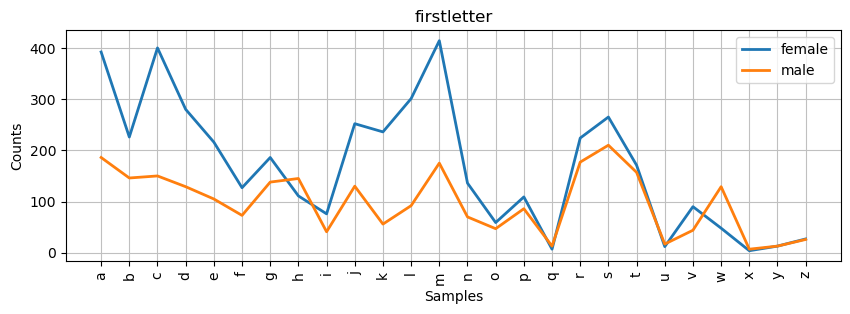

<Axes: title={'center': 'firstletter'}, xlabel='Samples', ylabel='Counts'>

In [96]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist(
    (gender, name[0].lower()) for name, gender in train_names)

# Normalize for male and female data
fem_count = float(len([gender for name, gender in train_names if gender == 'female']))
male_count = float(len([gender for name, gender in train_names if gender == 'male']))

for i in [counts for gender,counts in [i for i in cfd_firstletter.items()] if gender == 'male']:
    for freq in i.values():
        freq = freq/male_count
        
for i in [counts for gender,counts in [i for i in cfd_firstletter.items()] if gender == 'female']:
    for freq in i.values():
        freq = freq/fem_count

# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()

# 2. Last Letter

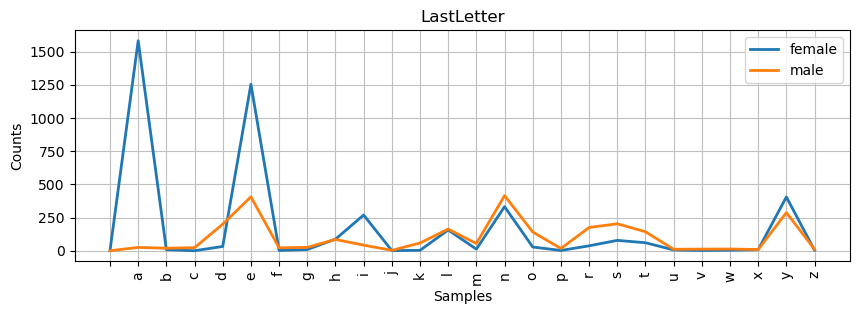

<Axes: title={'center': 'LastLetter'}, xlabel='Samples', ylabel='Counts'>

In [94]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist(
    (gender, name[-1].lower()) for name, gender in train_names)

# define title
titleName='LastLetter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()


Names that conclude with the letters 'a' and 'e' seem to serve as reliable indicators of female gender.

# 3. First 2 letters

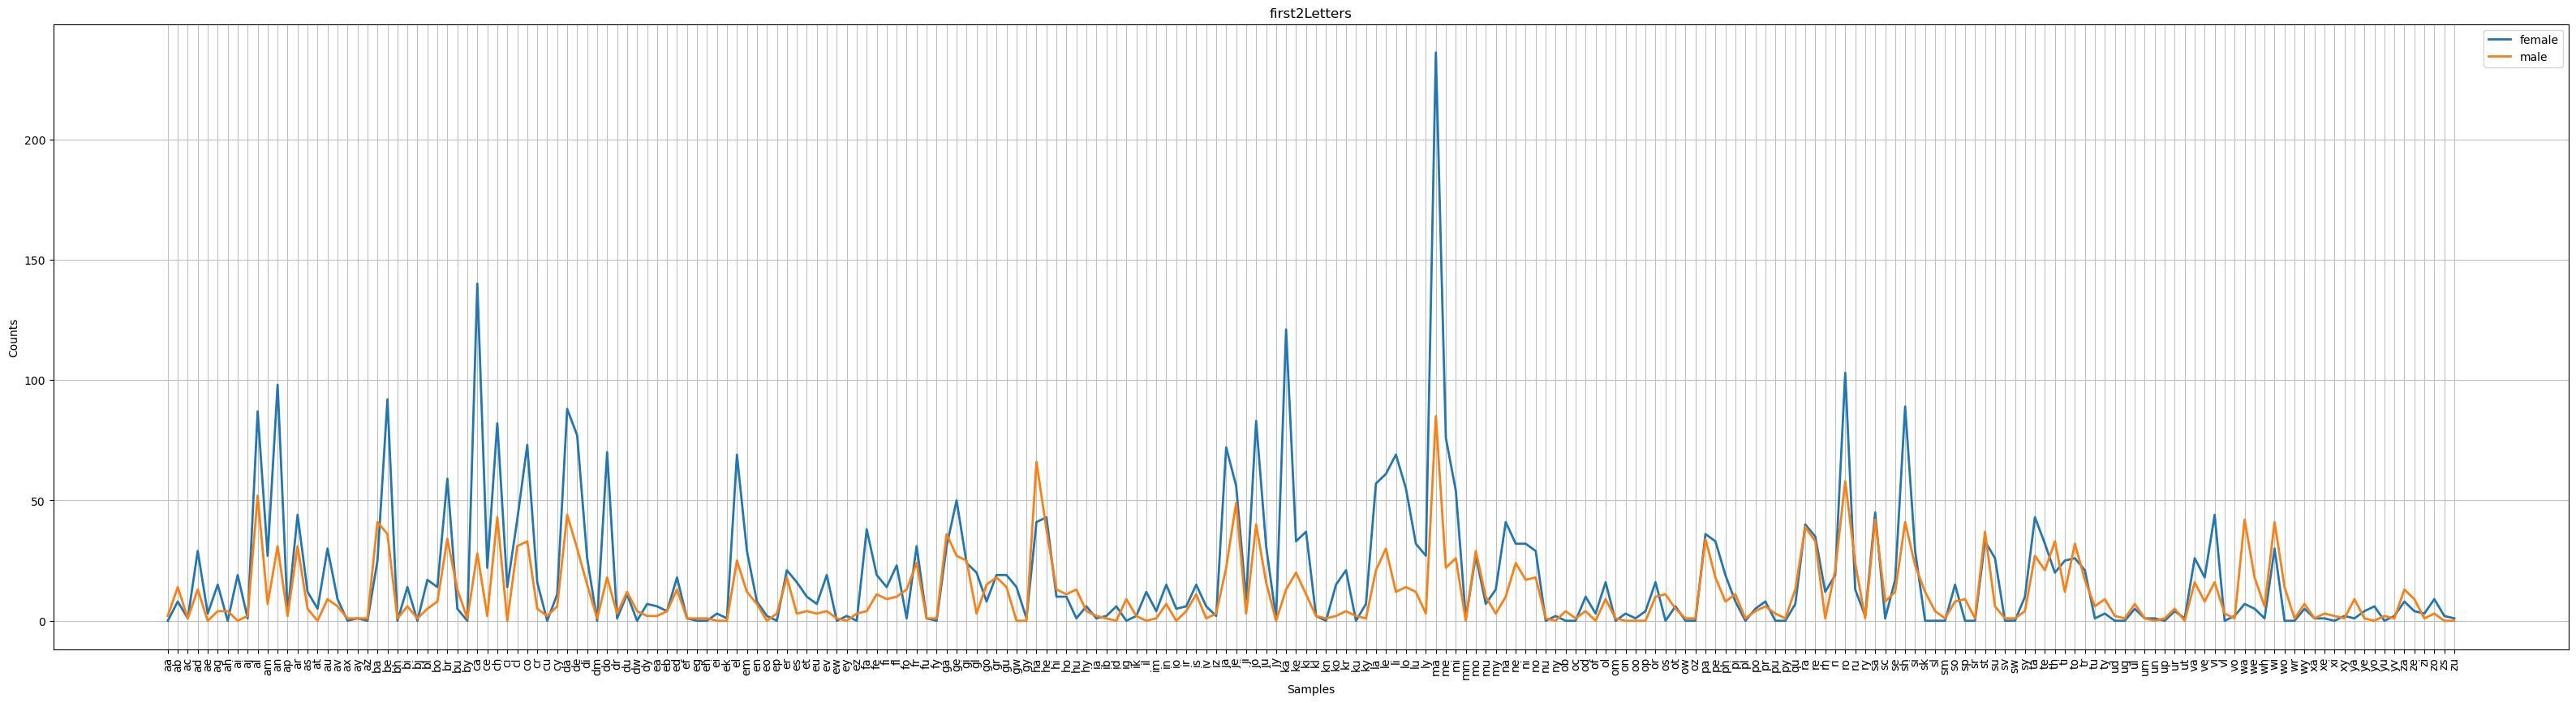

<Axes: title={'center': 'first2Letters'}, xlabel='Samples', ylabel='Counts'>

In [39]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist(
    (gender, name[:2].lower()) for name, gender in train_names)

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()


There appears to be a noticeable difference in the last two letters between male and female. We'll delve deeper into this characteristic since it's challenging to discern solely from the output.

# 4. Length

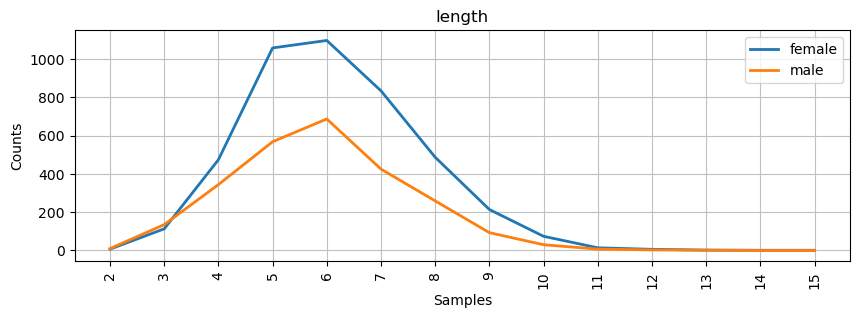

<Axes: title={'center': 'length'}, xlabel='Samples', ylabel='Counts'>

In [40]:
# length
cfd_length = nltk.ConditionalFreqDist(
    (gender, len(name)) for name, gender in train_names)

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

The length does not appear to be a great indicator of gender on its own.

# 5. Vowel Counts

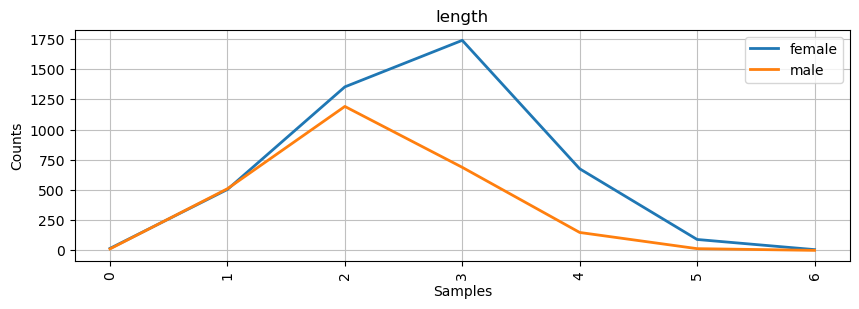

<Axes: title={'center': 'length'}, xlabel='Samples', ylabel='Counts'>

In [41]:
# Vowel Counts
cfd_vowels = nltk.ConditionalFreqDist(
    (gender, len(re.sub(r'[^aeiou]', '', name.lower()))) for name, gender in train_names)

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_vowels.plot()

# Concluding Remarks on Exploration

The initial examination of certain features provided a foundational understanding for feature selection. However, these features alone do not demonstrate strong predictive capabilities for gender classification. To develop a robust model, I must employ more sophisticated tools. My approach will involve constructing a feature extractor capable of generating multiple features, followed by the application of introductory machine learning techniques to optimize model performance.

Feature Extraction Methodology

The following section aims to iteratively enhance the feature extraction functions, which will subsequently be applied to both the development and test datasets.

Drawing from various examples in existing literature and the aforementioned analysis, I will commence our model development with the following features:

- First Letter: Recognizing that many names starting with vowels are often associated with females.
- First 2 letters
- Last letter
- Last 2 letters
- Last 3 letters
- Vowels count
- Hard consonants following general rules of 'c' and 'g'
- Soft consonants following general rules of 'c' and 'g'
- Syllable Count of names via textstat
- Name length
- Character count
- Presence of specific characters
- Count of each letter
- Count of pairs of letters in the alphabet

I have crafted a function capable of returning either a single feature or a combination of features based on input feature numbers.

In [42]:
def get_features(name,feat_num):
    '''
    Parameters:
        name - string of name to extract feature
        feat_num - itterable collection of integers specifying features. *Defaults to 1:9 inclusive
            1: first letter
            2: first 2 letters
            3: last letter
            4: last 2 letters
            5: last 3 letters
            6: Vowel counts
            7: Hard consonant count
            8: Soft consonant count
            9: Syllable Count
            10: Name length
            11: char count --> feature for all alpha chars
            12: char present --> feature for all alpha chars (boolean)
            13: count each letter
            14: Count pairs
    Returns:
        features: a dictionary of extracted features
    '''
    features = {}    
        
    # Converts feat_num to itterable if type is int
    if type(feat_num) is int:
        feat_num = (0, feat_num)        
       
    # Gender Feature 1: First letter - book example
    if 1 in feat_num:
        features['firstletter'] = name[0].lower()
            
    # Gender Feature 2: First 2 letters
    if 2 in feat_num:
        features['first2Letters'] = name[0:2].lower()
            
    # Gender Feature 3: last letter
    if 3 in feat_num:
        features['last_letter'] = name[-1].lower()
            
    # Gender Feature 4: last 2 letter
    if 4 in feat_num:
        features["last2letters"] = name[-2:].lower()
        
    # Gender feature 5: last 3 letter
    if 5 in feat_num:  
        features["last3letters"] = name[-3:].lower()
            
    # Gender feature 6: Vowels count
    if 6 in feat_num:  
        features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))
            
    # Gender Feature 7: Hard consonants using general rules of c and g
    if 7 in feat_num:
        features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2
            
    # Gender Feature 8: Soft consonants using general rules of c and g
    if 8 in feat_num:
            features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2
            
    # Gender Feature 9: Syllable Count of names via textstat
    if 9 in feat_num:
        features['syllable_count'] = textstat.syllable_count(name.lower())
    
    # Gender Feature 10: Name length
    if 10 in feat_num:
        features["length"] = len(name)
    
    # Gender Feature 11: Char Counts (overfitts)
    if 11 in feat_num:
        for letter in string.ascii_lowercase:
            features["count_{0}".format(letter)] = name.lower().count(letter)
                
    # Gender Feature 12: Char Booleans (overfitts)
    if 12 in feat_num:
        for letter in string.ascii_lowercase:
            features["has_{0}".format(letter)] = letter in name.lower()
        
        
    if 13 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter in letters:
            features["count(%s)" % letter] = name.lower().count(letter)


    if 14 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            for letter2 in letters:
                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
        
    #### Complex Features
    # Gender Feature 15: Last Letter/Last 2 Letter
    if 15 in feat_num:
        features = {}
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
            
    if 16 in feat_num:
        features = {}
        features["firstletter"] = name[0].lower()
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
        features["last3letter"] = name[-3:].lower()

        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            features["count("+letter1+")"] = name.lower().count(letter1)
            features["has("+letter1+")"] = (letter1 in name.lower())
            # iterate over 2-grams
            for letter2 in letters:

                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())


    if 17 in feat_num:
        # define features
        features = {}
        # has(fo) = True
        features["has(fo)"] = ('fo' in name.lower())
        # has(hu) = True
        features["has(hu)"] = ('hu' in name.lower())
        # has(rv) = True
        features["has(rv)"] = ('rv' in name.lower())    
        # has(rw) = True
        features["has(rw)"] = ('rw' in name.lower()) 
        # has(sp) = True
        features["has(sp)"] = ('sp' in name.lower())

        # lastletter = 'a'
        features["lastletter=a"] = ('a' in name[-1:].lower())
        # lastletter = 'f'
        features["lastletter=f"] = ('f' in name[-1:].lower())
        # lastletter = 'k'
        features["lastletter=k"] = ('k' in name[-1:].lower())

        # last2letter = 'ch'
        features["last2letter=ch"] = ('ch' in name[-2:].lower())
        # last2letter = 'do'
        features["last2letter=do"] = ('do' in name[-2:].lower())
        # last2letter = 'ia'
        features["last2letter=ia"] = ('ia' in name[-2:].lower())
        # last2letter = 'im'
        features["last2letter=im"] = ('im' in name[-2:].lower())
        # last2letter = 'io'
        features["last2letter=io"] = ('io' in name[-2:].lower())
        # last2letter = 'la'
        features["last2letter=la"] = ('la' in name[-2:].lower())
        # last2letter = 'ld'
        features["last2letter=ld"] = ('ld' in name[-2:].lower())
        # last2letter = 'na'
        features["last2letter=na"] = ('na' in name[-2:].lower())
        # last2letter = 'os'
        features["last2letter=os"] = ('os' in name[-2:].lower())
        # last2letter = 'ra'
        features["last2letter=ra"] = ('ra' in name[-2:].lower())
        # last2letter = 'rd'
        features["last2letter=rd"] = ('rd' in name[-2:].lower())
        # last2letter = 'rt'
        features["last2letter=rt"] = ('rt' in name[-2:].lower())
        # last2letter = 'sa'
        features["last2letter=sa"] = ('sa' in name[-2:].lower())
        # last2letter = 'ta'
        features["last2letter=ta"] = ('ta' in name[-2:].lower())
        # last2letter = 'us'
        features["last2letter=us"] = ('us' in name[-2:].lower())

        # last3letter = 'ana'
        features["last3letter=ana"] = ('ana' in name[-3:].lower())    
        # last3letter = u'ard'
        features["last3letter=ard"] = ('ard' in name[-3:].lower())        
        # last3letter = u'ita'
        features["last3letter=ita"] = ('ita' in name[-3:].lower())    
        # last3letter = u'nne'
        features["last3letter=nne"] = ('nne' in name[-3:].lower())    
        # last3letter = u'tta'
        features["last3letter=tta"] = ('tta' in name[-3:].lower())    
        
    return features

# Functions for Analysis and Helper Functions

I have developed a few functions to facilitate the analysis and display of results:

- normalize_confusion_matrix: Returns a normalized confusion matrix.
- plot_confusion_matrix: Plots a confusion matrix.
- plot_both_confusion_matrix: Plots two confusion matrices side by side.
- evaluate_naive_bayes_classifier: Trains a model using the naive Bayes classifier.
- evaluate_decision_tree_classifier: Trains a model using the decision tree classifier.
- get_sorted_feature_accuracies: Returns a tuple of sorted features and their corresponding accuracies in the dataset.
- optimized_solution: Returns a tuple containing a list of features that yield the highest accuracy and the achieved accuracy.

Helper Functions:

- generate_errors
- show_errors
- generate_prediction

These functions aim to streamline the analysis process and aid in the interpretation of results.

In [43]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

def evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.DecisionTreeClassifier.train(train_set)
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier
 
    
def get_sorted_feature_accuracies(feat_num_start, feat_num, model_id):
        feature_accuracy = {}
        for i in numpy.arange(feat_num_start, feat_num+1):
            feat_num =int(i)
            errors = []
            
            # devtest-set and training set are constructed
            #random.shuffle(development_set_names)
            #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
            train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
            devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
            test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names] 
            
            if (model_id == 'nbc'):
                classifier = nltk.NaiveBayesClassifier.train(train_set)
            elif (model_id == 'dtc'):
                classifier = nltk.DecisionTreeClassifier.train(train_set)
                  
            # For errors list
            for (name, tag) in devtest_names:
                guess = classifier.classify(get_features(name,feat_num)) 
                if guess != tag: 
                    errors.append((tag, guess, name))    
                    
            
            feature_accuracy[feat_num] = nltk.classify.accuracy(classifier, devtest_set)
        
        
        #sort for accuracy, and then reverse the array to return the array as most accurate to least accurate
        sorted_by_accuracy = sorted(feature_accuracy.items(), key=operator.itemgetter(1))
        return sorted_by_accuracy[::-1]
                  
def optimized_solution(model_id):
    # for each of the features, append to the list of features, and check if the accuracy
    #went up or down. If it went down, take it out, if it went up, make that the new accuracy to beat.
        
    optimized_feature_list = []
    last_accuracy = -1
    for feat_num in range(1,15):
        errors = []
        optimized_feature_list.append(feat_num)
            
        #random.shuffle(development_set_names)
        #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
        train_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in train_names]
        devtest_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in devtest_names]
        test_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in test_names] 
            
        if (model_id == 'nbc'):
            classifier = nltk.NaiveBayesClassifier.train(train_set)
        elif (model_id == 'dtc'):
            classifier = nltk.DecisionTreeClassifier.train(train_set) 
            
        for (name, tag) in devtest_names:
            guess = classifier.classify(get_features(name,optimized_feature_list)) 
            if guess != tag: 
                errors.append((tag, guess, name))    
                    
            
        current_accuracy= nltk.classify.accuracy(classifier, devtest_set)
        if current_accuracy > last_accuracy: 
            last_accuracy = current_accuracy
        else:
            del optimized_feature_list[-1]
            
    return (optimized_feature_list, last_accuracy)     

### Helper functions:

# Generic function to generate an error list based the arguments provided
# Accepts the classifer, names dataset, and the extractor function
# Returns the list of errors

def generate_errors(classifier, dataset, feat_num): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name,feat_num)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

# Generic function to display classification errors
# Accepts the error list and an optional argument to show only n number of errors

def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

        
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

# Models for Gender Identification - Naive Bayes Classifier:

Utilizing the basic features identified earlier, I will assess the performance of the model for each.

# Feature 1 - Initial Letter:

In this model, I will train a Naive Bayes classifier using a straightforward feature set, focusing solely on the first letter of the name.

Accuracy (Train): 0.6496255760368663
Accuracy (Development Test): 0.658


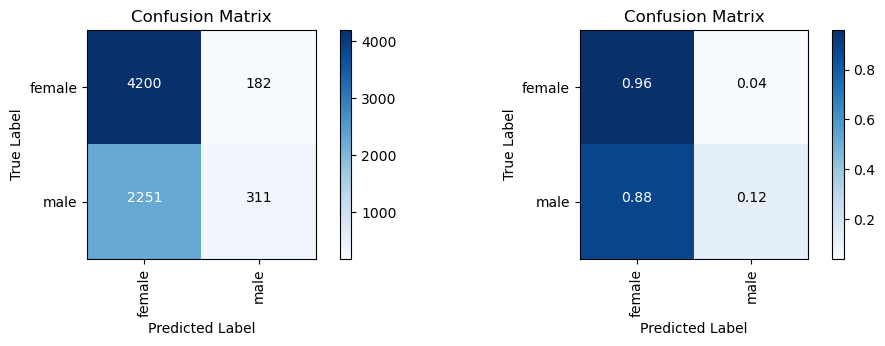

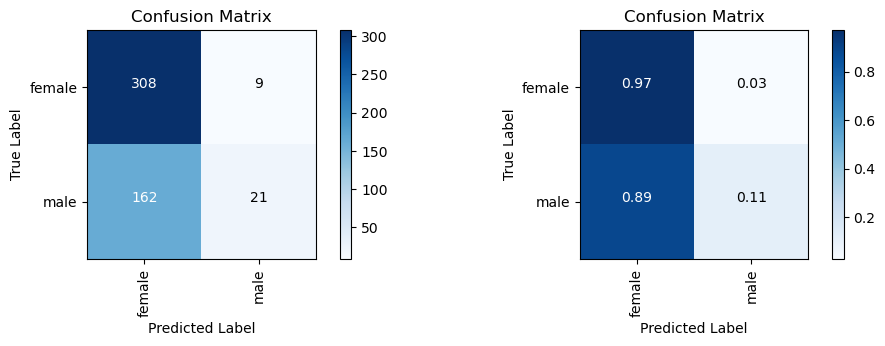

In [44]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    devtest_accuracy_nb1, devtest_cm_nb1,devtest_label_names_nb1, \
    devtest_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb1,['female','male'])

In [45]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb1)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.6511    0.9585    0.7754      4382
        male     0.6308    0.1214    0.2036      2562

    accuracy                         0.6496      6944
   macro avg     0.6409    0.5399    0.4895      6944
weighted avg     0.6436    0.6496    0.5644      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.6553    0.9716    0.7827       317
        male     0.7000    0.1148    0.1972       183

    accuracy                         0.6580       500
   macro avg     0.6777    0.5432    0.4900       500
weighted avg     0.6717    0.6580    0.5684       500



In [46]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb1.show_most_informative_features(n_informative_features)

Most Informative Features
             firstletter = 'w'              male : female =      4.6 : 1.0
             firstletter = 'q'              male : female =      3.1 : 1.0
             firstletter = 'x'              male : female =      2.8 : 1.0
             firstletter = 'k'            female : male   =      2.5 : 1.0
             firstletter = 'u'              male : female =      2.4 : 1.0
             firstletter = 'h'              male : female =      2.2 : 1.0
             firstletter = 'l'            female : male   =      1.9 : 1.0
             firstletter = 'y'              male : female =      1.7 : 1.0
             firstletter = 'z'              male : female =      1.6 : 1.0
             firstletter = 't'              male : female =      1.6 : 1.0
             firstletter = 'c'            female : male   =      1.6 : 1.0
             firstletter = 'm'            female : male   =      1.4 : 1.0
             firstletter = 'o'              male : female =      1.4 : 1.0

In [47]:
# Show error 
show_errors(generate_errors(classifier_nb1, devtest_names, feat_num))

correct=female   guess=male     name=Hadria                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Hestia                        
correct=female   guess=male     name=Hollie                        
correct=female   guess=male     name=Wenonah                       
correct=female   guess=male     name=Winnifred                     
correct=female   guess=male     name=Wren                          
correct=female   guess=male     name=Wrennie                       
correct=female   guess=male     name=Xenia                         
correct=male     guess=female   name=Adam                          
correct=male     guess=female   name=Adams                         
correct=male     guess=female   name=Adger                         
correct=male     guess=female   name=Alastair                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Amadeus    

First letter alone does not lead to very good results as is indicated by the analysis above.

# Feature 2 - First 2 letters
I will now consider the first 2 letters as our feature.

Accuracy (Train): 0.6856278801843319
Accuracy (Development Test): 0.684


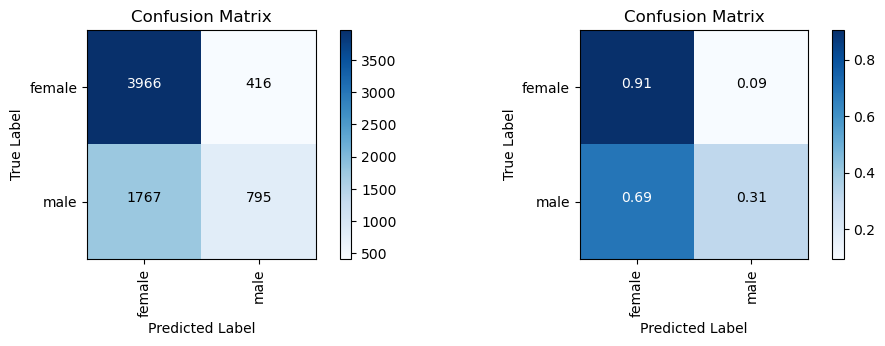

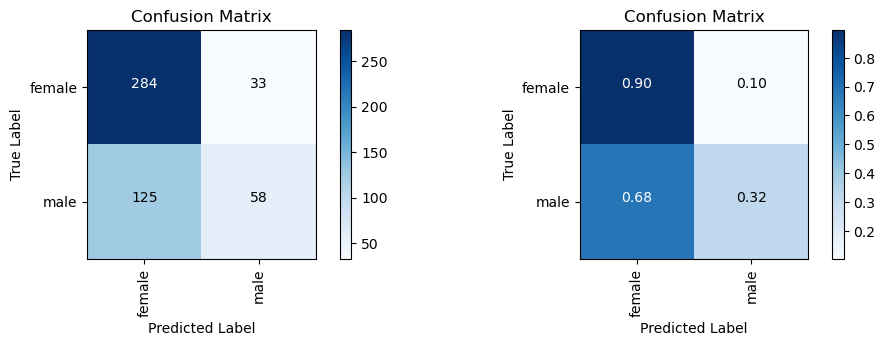

In [53]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb2,train_cm_nb2,train_label_names_nb2,train_report_nb2, \
    devtest_accuracy_nb2, devtest_cm_nb2,devtest_label_names_nb2, \
    devtest_report_nb2, classifier_nb2=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb2))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb2,['female','male'])

In [54]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb2.show_most_informative_features(n_informative_features)


Most Informative Features
           first2Letters = 'fo'             male : female =     15.1 : 1.0
           first2Letters = 'hu'             male : female =     15.1 : 1.0
           first2Letters = 'ya'             male : female =     10.6 : 1.0
           first2Letters = 'sc'             male : female =      9.5 : 1.0
           first2Letters = 'wa'             male : female =      9.5 : 1.0
           first2Letters = 'tu'             male : female =      7.3 : 1.0
           first2Letters = 'wh'             male : female =      7.3 : 1.0
           first2Letters = 'we'             male : female =      5.7 : 1.0
           first2Letters = 'ce'           female : male   =      5.4 : 1.0
           first2Letters = 'ka'           female : male   =      5.4 : 1.0
           first2Letters = 'fa'           female : male   =      5.1 : 1.0
           first2Letters = 'rh'           female : male   =      5.0 : 1.0
           first2Letters = 'ly'           female : male   =      4.7 : 1.0

In [55]:
# Show error 
show_errors(generate_errors(classifier_nb2, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Barbaraanne                   
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gabriella                     
correct=female   guess=male     name=Gigi                          
correct=female   guess=male     name=Gilbertine                    
correct=female   guess=male     name=Ginni                         
correct=female   guess=male     name=Giorgia                       
correct=female   guess=male     name=Giovanna                      
correct=female   guess=male     name=Gisele                        
correct=female   guess=male     name=Hadria                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Hollie                        
correct=female   guess=male     name=Moira                         
correct=female   guess=male     name=Molly      

Initial observations suggest that first letter features may not be optimal for model development. Consequently, I will shift my focus to consider features related to the last letter(s).

# Feature 3 - Last Letter

My attention will now be directed towards analyzing the last letter of the name. Through our preliminary feature exploration, discernible patterns have emerged, which are potentially exploitable by our classifier.

Accuracy (Train): 0.7654089861751152
Accuracy (Development Test): 0.76


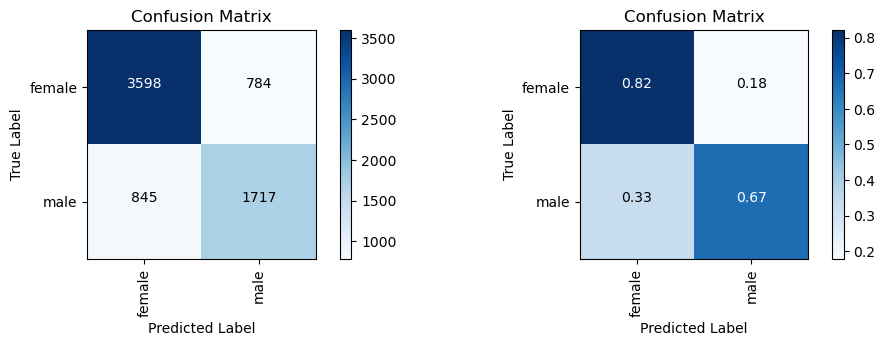

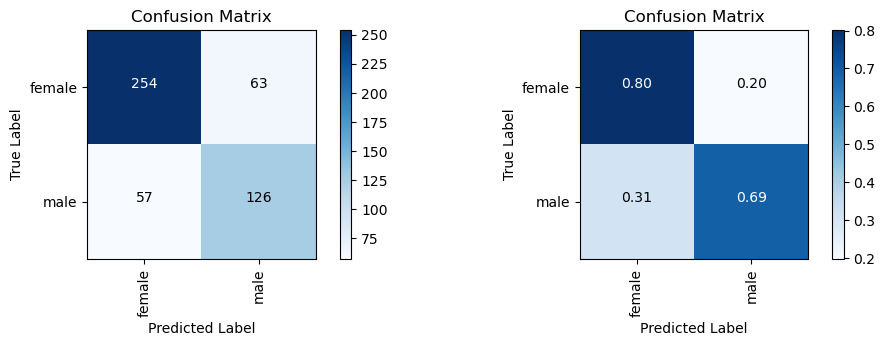

In [56]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb3,train_cm_nb3,train_label_names_nb3,train_report_nb3, \
    devtest_accuracy_nb3, devtest_cm_nb3,devtest_label_names_nb3, \
    devtest_report_nb3, classifier_nb3=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb3))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb3,['female','male'])

In [57]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb3.show_most_informative_features(n_informative_features)

Most Informative Features
             last_letter = 'a'            female : male   =     36.4 : 1.0
             last_letter = 'k'              male : female =     28.5 : 1.0
             last_letter = 'f'              male : female =     15.4 : 1.0
             last_letter = 'p'              male : female =     11.9 : 1.0
             last_letter = 'd'              male : female =     10.5 : 1.0
             last_letter = 'v'              male : female =      8.5 : 1.0
             last_letter = 'o'              male : female =      8.5 : 1.0
             last_letter = 'r'              male : female =      8.0 : 1.0
             last_letter = 'm'              male : female =      7.4 : 1.0
             last_letter = 'w'              male : female =      5.1 : 1.0
             last_letter = 'g'              male : female =      4.6 : 1.0
             last_letter = 's'              male : female =      4.4 : 1.0
             last_letter = 'z'              male : female =      4.4 : 1.0

In [58]:
show_errors(generate_errors(classifier_nb3, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Adel                          
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Anne-Mar                      
correct=female   guess=male     name=Arleen                        
correct=female   guess=male     name=Bess                          
correct=female   guess=male     name=Bryn                          
correct=female   guess=male     name=Caitlin                       
correct=female   guess=male     name=Caitrin                       
correct=female   guess=male     name=Cal                           
correct=female   guess=male     name=Carlyn                        
correct=female   guess=male     name=Carol-Jean                    
correct=female   guess=male     name=Caroleen                      
correct=female   guess=male     name=Carroll                       
correct=female   guess=male     name=Caryl      

Even though names ending with the letter 'a' ranked as our second-best feature within this feature set, other rules that seemed promising for gender prediction did not rank highly.

This might be attributed to my exploration of conditional frequency rather than percent conditional frequency.

# Regarding Feature 4 - Last 2 letters:

Within this model, I employed a Naive Bayes classifier trained on a feature set consisting of the first two letters of a name.

Accuracy (Train): 0.8034274193548387
Accuracy (Development Test): 0.8


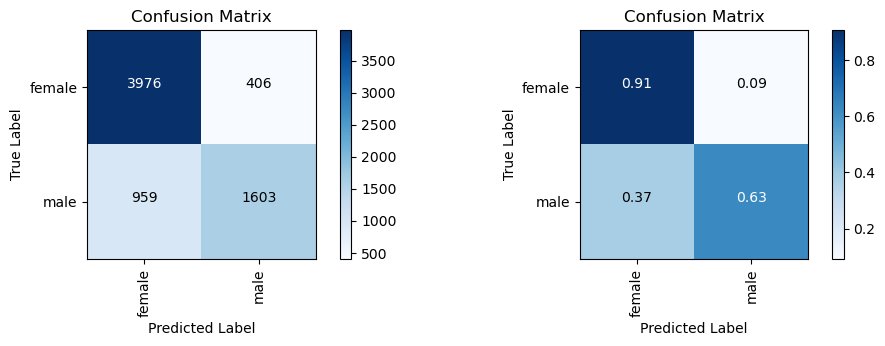

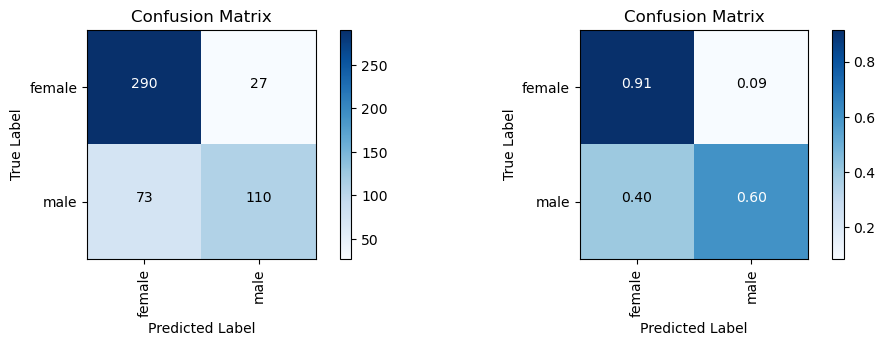

In [59]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb4,train_cm_nb4,train_label_names_nb4,train_report_nb4, \
    devtest_accuracy_nb4, devtest_cm_nb4,devtest_label_names_nb4, \
    devtest_report_nb4, classifier_nb4=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb4))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb4,['female','male'])

In [60]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb4.show_most_informative_features(n_informative_features)

Most Informative Features
            last2letters = 'na'           female : male   =    158.2 : 1.0
            last2letters = 'la'           female : male   =     69.1 : 1.0
            last2letters = 'ia'           female : male   =     36.8 : 1.0
            last2letters = 'sa'           female : male   =     34.8 : 1.0
            last2letters = 'ra'           female : male   =     33.6 : 1.0
            last2letters = 'ta'           female : male   =     31.8 : 1.0
            last2letters = 'rd'             male : female =     31.3 : 1.0
            last2letters = 'us'             male : female =     28.0 : 1.0
            last2letters = 'do'             male : female =     25.1 : 1.0
            last2letters = 'io'             male : female =     24.0 : 1.0
            last2letters = 'ld'             male : female =     23.1 : 1.0
            last2letters = 'rt'             male : female =     22.3 : 1.0
            last2letters = 'os'             male : female =     17.3 : 1.0

In [61]:
# Show error 
show_errors(generate_errors(classifier_nb4, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Anne-Mar                      
correct=female   guess=male     name=Caitlin                       
correct=female   guess=male     name=Caitrin                       
correct=female   guess=male     name=Carol-Jean                    
correct=female   guess=male     name=Carroll                       
correct=female   guess=male     name=Charlot                       
correct=female   guess=male     name=Cloe                          
correct=female   guess=male     name=Darell                        
correct=female   guess=male     name=Diamond                       
correct=female   guess=male     name=Gennifer                      
correct=female   guess=male     name=Greer                         
correct=female   guess=male     name=Janot                         
correct=female   guess=male     name=Joan       

# Gender Identification Models - Decision Tree Classifier:

Employing the previously identified simple features, I will evaluate the performance of the model for each.

# Feature 1 - First Letter:
In this model, I will train a Decision Tree classifier using a basic feature set, specifically focusing on the first letter of the name.

Accuracy (Train): 0.6496255760368663
Accuracy (Development Test): 0.658


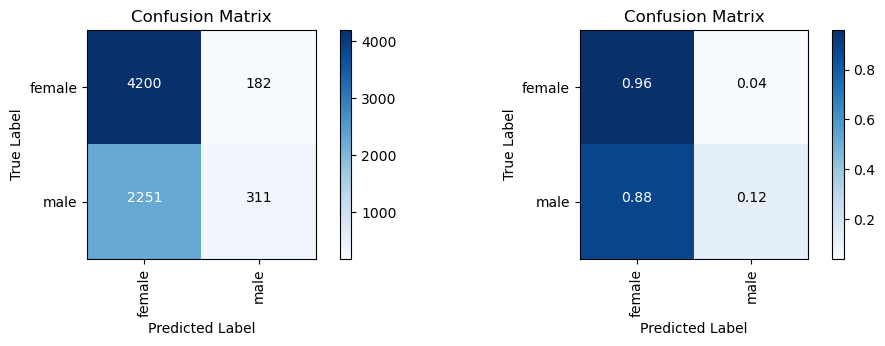

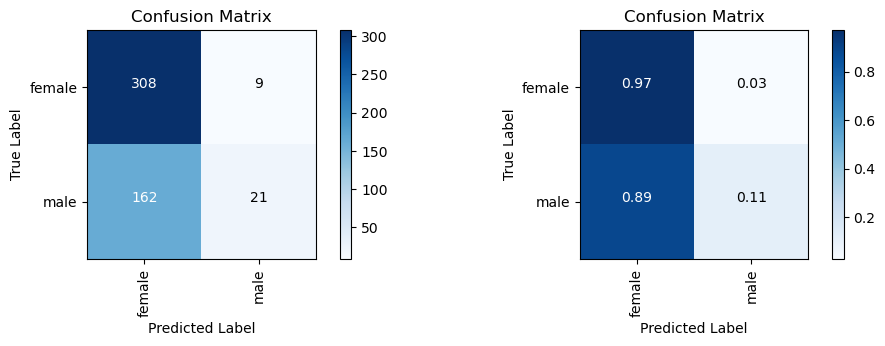

In [65]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt1,train_cm_dt1,train_label_names_dt1,train_report_dt1,devtest_accuracy_dt1, devtest_cm_dt1,devtest_label_names_dt1,devtest_report_dt1, classifier_dt1=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt1))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt1,['female','male'])

In [66]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt1)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.6511    0.9585    0.7754      4382
        male     0.6308    0.1214    0.2036      2562

    accuracy                         0.6496      6944
   macro avg     0.6409    0.5399    0.4895      6944
weighted avg     0.6436    0.6496    0.5644      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.6553    0.9716    0.7827       317
        male     0.7000    0.1148    0.1972       183

    accuracy                         0.6580       500
   macro avg     0.6777    0.5432    0.4900       500
weighted avg     0.6717    0.6580    0.5684       500



In [67]:
# Show error 
show_errors(generate_errors(classifier_dt1, devtest_names, feat_num))

correct=female   guess=male     name=Hadria                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Hestia                        
correct=female   guess=male     name=Hollie                        
correct=female   guess=male     name=Wenonah                       
correct=female   guess=male     name=Winnifred                     
correct=female   guess=male     name=Wren                          
correct=female   guess=male     name=Wrennie                       
correct=female   guess=male     name=Xenia                         
correct=male     guess=female   name=Adam                          
correct=male     guess=female   name=Adams                         
correct=male     guess=female   name=Adger                         
correct=male     guess=female   name=Alastair                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Amadeus    

# Feature 2 - Initial 2 Letters

In this model, I trained a Decision Tree classifier utilizing the first 2 letters of each name.

Accuracy (Train): 0.6856278801843319
Accuracy (Development Test): 0.686


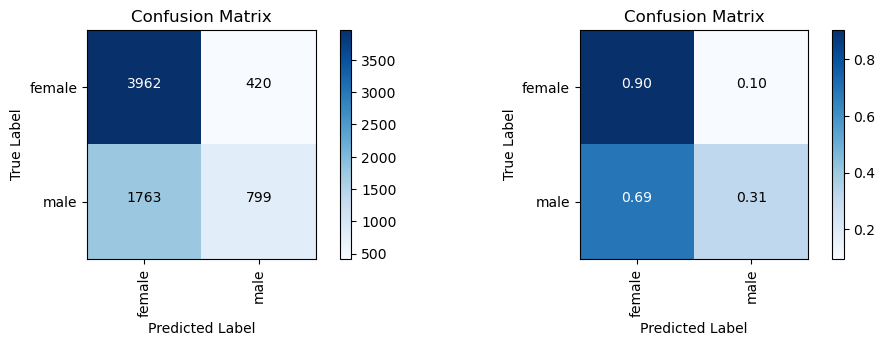

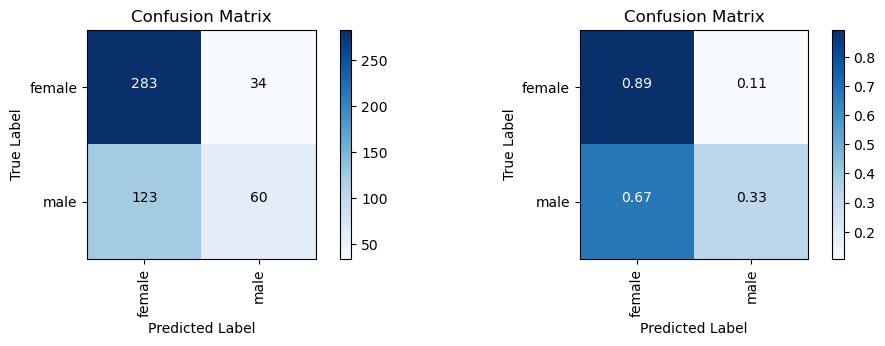

In [68]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_dt2,train_cm_dt2,train_label_names_dt2,train_report_dt2,devtest_accuracy_dt2, devtest_cm_dt2,devtest_label_names_dt2,devtest_report_dt2, classifier_dt2=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt2))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt2,['female','male'])

Accuracy (Train): 0.6856278801843319
Accuracy (Development Test): 0.686


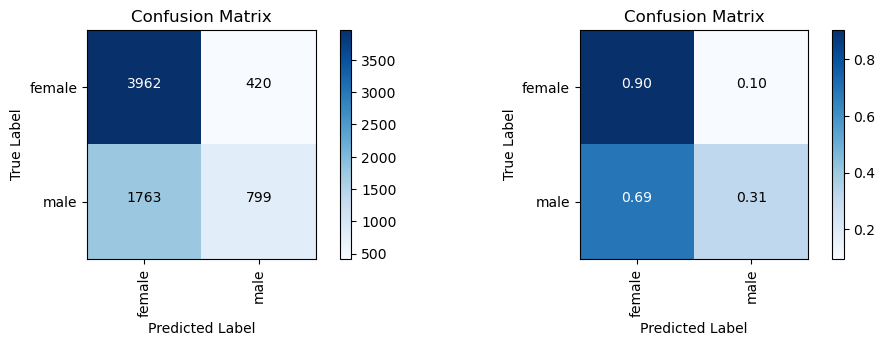

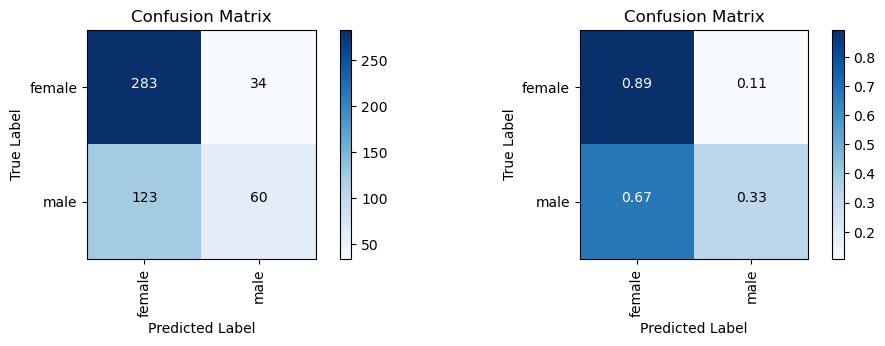

In [69]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_dt2,train_cm_dt2,train_label_names_dt2,train_report_dt2,devtest_accuracy_dt2, devtest_cm_dt2,devtest_label_names_dt2,devtest_report_dt2, classifier_dt2=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt2))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt2,['female','male'])

In [71]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt2)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.6921    0.9042    0.7840      4382
        male     0.6555    0.3119    0.4226      2562

    accuracy                         0.6856      6944
   macro avg     0.6738    0.6080    0.6033      6944
weighted avg     0.6785    0.6856    0.6507      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.6970    0.8927    0.7828       317
        male     0.6383    0.3279    0.4332       183

    accuracy                         0.6860       500
   macro avg     0.6677    0.6103    0.6080       500
weighted avg     0.6755    0.6860    0.6549       500



In [70]:
# Show error 
show_errors(generate_errors(classifier_dt2, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Barbaraanne                   
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gabriella                     
correct=female   guess=male     name=Gigi                          
correct=female   guess=male     name=Gilbertine                    
correct=female   guess=male     name=Ginni                         
correct=female   guess=male     name=Giorgia                       
correct=female   guess=male     name=Giovanna                      
correct=female   guess=male     name=Gisele                        
correct=female   guess=male     name=Hadria                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Hollie                        
correct=female   guess=male     name=Klara                         
correct=female   guess=male     name=Moira      

# Feature 3 - Last Letter

In this approach, I trained a Decision Tree classifier by utilizing the last letter of each name.

Accuracy (Train): 0.7654089861751152
Accuracy (Development Test): 0.76


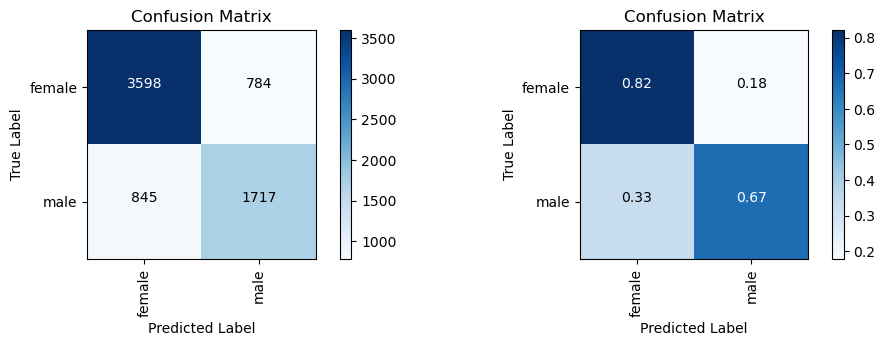

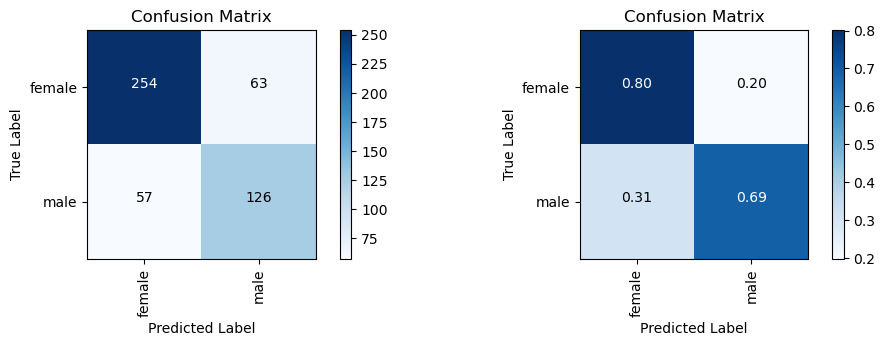

In [72]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features3
train_accuracy_dt3,train_cm_dt3,train_label_names_dt3,train_report_dt3,devtest_accuracy_dt3, devtest_cm_dt3,devtest_label_names_dt3,devtest_report_dt3, classifier_dt3=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt3))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt3,['female','male'])

In [73]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt3)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.8098    0.8211    0.8154      4382
        male     0.6865    0.6702    0.6783      2562

    accuracy                         0.7654      6944
   macro avg     0.7482    0.7456    0.7468      6944
weighted avg     0.7643    0.7654    0.7648      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.8167    0.8013    0.8089       317
        male     0.6667    0.6885    0.6774       183

    accuracy                         0.7600       500
   macro avg     0.7417    0.7449    0.7432       500
weighted avg     0.7618    0.7600    0.7608       500



In [74]:
# Show error 
show_errors(generate_errors(classifier_dt3, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Adel                          
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Anne-Mar                      
correct=female   guess=male     name=Arleen                        
correct=female   guess=male     name=Bess                          
correct=female   guess=male     name=Bryn                          
correct=female   guess=male     name=Caitlin                       
correct=female   guess=male     name=Caitrin                       
correct=female   guess=male     name=Cal                           
correct=female   guess=male     name=Carlyn                        
correct=female   guess=male     name=Carol-Jean                    
correct=female   guess=male     name=Caroleen                      
correct=female   guess=male     name=Carroll                       
correct=female   guess=male     name=Caryl      

# Feature 4 - Last 2 Letters

In this model, I trained a Decision Tree classifier utilizing the final 2 letters of each name.

Accuracy (Train): 0.8034274193548387
Accuracy (Development Test): 0.804


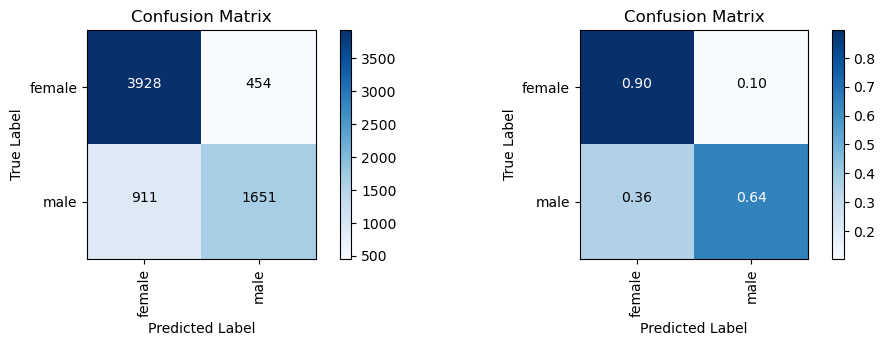

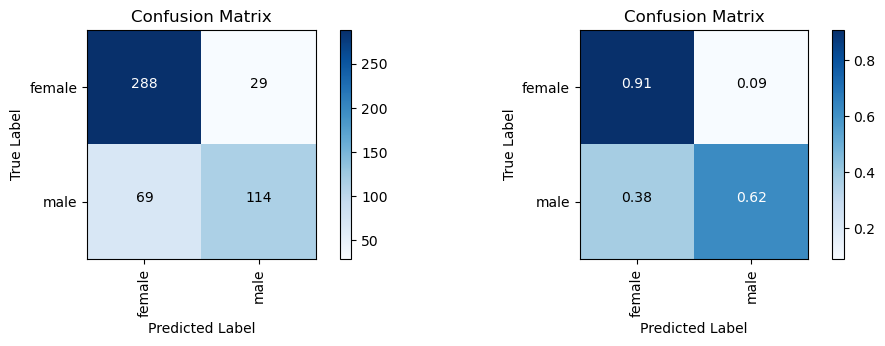

In [75]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt4,train_cm_dt4,train_label_names_dt4,train_report_dt4,devtest_accuracy_dt4, devtest_cm_dt4,devtest_label_names_dt4,devtest_report_dt4, classifier_dt4=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt4))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt4,['female','male'])

In [76]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt4)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.8117    0.8964    0.8520      4382
        male     0.7843    0.6444    0.7075      2562

    accuracy                         0.8034      6944
   macro avg     0.7980    0.7704    0.7797      6944
weighted avg     0.8016    0.8034    0.7987      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.8067    0.9085    0.8546       317
        male     0.7972    0.6230    0.6994       183

    accuracy                         0.8040       500
   macro avg     0.8020    0.7657    0.7770       500
weighted avg     0.8032    0.8040    0.7978       500



In [77]:
# Show error 
show_errors(generate_errors(classifier_dt4, devtest_names, feat_num))

correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Anne-Mar                      
correct=female   guess=male     name=Caitlin                       
correct=female   guess=male     name=Caitrin                       
correct=female   guess=male     name=Carol-Jean                    
correct=female   guess=male     name=Carroll                       
correct=female   guess=male     name=Charlot                       
correct=female   guess=male     name=Cloe                          
correct=female   guess=male     name=Darell                        
correct=female   guess=male     name=Diamond                       
correct=female   guess=male     name=Gennifer                      
correct=female   guess=male     name=Greer                         
correct=female   guess=male     name=Janot                         
correct=female   guess=male     name=Joan       

# Feature Optimization

To construct the most effective Naive Bayes model, I will identify the optimal features based on their accuracy ratings.

In [79]:
ranked_features = get_sorted_feature_accuracies(1, 4, 'dtc')

In [80]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
}

print("Top Two Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:2]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

Top Two Single Features with the Highest Accuracy
---------------------------------------------------------------
Feature: Last 2 Letters                 Accuracy: 0.804   
Feature: Last Letter                    Accuracy: 0.76    
---------------------------------------------------------------


In [82]:
optimized_features = optimized_solution('dtc')
optimized_features

KeyboardInterrupt: 

I observe that the optimized solution resulted in an accuracy of 0.76, whereas the highest accuracy achieved by any single feature was 0.804. It seems that there is a case of overfitting with the optimization approach for the decision tree classifier. Therefore, I have decided not to use this feature set for the best model for the decision tree classifier.

The following features contributed to the optimized solution:

In [ ]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))